<a href="https://colab.research.google.com/github/TIAGOOOLIVEIRA/quantum-vs-classical-computing-benchmarks/blob/main/IBM_Qiskit_quantum_diagonalization_of_a_chemistry_Hamiltonian.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install qiskit qiskit-ibm-runtime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 378.6/378.6 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 30.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 6.0 MB/s eta 0:00:00


In [ ]:
%pip install qiskit-ibm-runtime
%pip install qiskit-addon-sqd
%pip install ffsim
%pip install qiskit-serverless

In [4]:
import pyscf
import pyscf.cc
import pyscf.mcscf
import ffsim
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit, QuantumRegister
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler

In [5]:
# Specify molecule properties
open_shell = False
spin_sq = 0

# Build N2 molecule
mol = pyscf.gto.Mole()
mol.build(
    atom=[["N", (0, 0, 0)], ["N", (1.0, 0, 0)]],
    basis="cc-pvdz",
    symmetry="Dooh",
)

# Define active space
n_frozen = 2
active_space = range(n_frozen, mol.nao_nr())

# Get molecular integrals
scf = pyscf.scf.RHF(mol).run()
num_orbitals = len(active_space)
n_electrons = int(sum(scf.mo_occ[active_space]))
num_elec_a = (n_electrons + mol.spin) // 2
num_elec_b = (n_electrons - mol.spin) // 2
cas = pyscf.mcscf.CASCI(scf, num_orbitals, (num_elec_a, num_elec_b))
mo = cas.sort_mo(active_space, base=0)
hcore, nuclear_repulsion_energy = cas.get_h1cas(mo)
eri = pyscf.ao2mo.restore(1, cas.get_h2cas(mo), num_orbitals)

# Store reference energy from SCI calculation performed separately
exact_energy = -109.22690201485733

converged SCF energy = -108.929838385609


In [6]:
# Get CCSD t2 amplitudes for initializing the ansatz
ccsd = pyscf.cc.CCSD(
    scf, frozen=[i for i in range(mol.nao_nr()) if i not in active_space]
).run()
t1 = ccsd.t1
t2 = ccsd.t2

E(CCSD) = -109.2177884185544  E_corr = -0.2879500329450031


In [7]:
n_reps = 1
alpha_alpha_indices = [(p, p + 1) for p in range(num_orbitals - 1)]
alpha_beta_indices = [(p, p) for p in range(0, num_orbitals, 4)]


ucj_op = ffsim.UCJOpSpinBalanced.from_t_amplitudes(
    t2=t2,
    t1=t1,
    n_reps=n_reps,
    interaction_pairs=(alpha_alpha_indices, alpha_beta_indices),
    # Setting optimize=True enables the "compressed" factorization
    optimize=True,
    # Limit the number of optimization iterations to prevent the code cell from running
    # too long. Removing this line may improve results.
    options=dict(maxiter=1000),
)

nelec = (num_elec_a, num_elec_b)

# create an empty quantum circuit
qubits = QuantumRegister(2 * num_orbitals, name="q")
circuit = QuantumCircuit(qubits)

# prepare Hartree-Fock state as the reference state and append it to the quantum circuit
circuit.append(ffsim.qiskit.PrepareHartreeFockJW(num_orbitals, nelec), qubits)

# apply the UCJ operator to the reference state
circuit.append(ffsim.qiskit.UCJOpSpinBalancedJW(ucj_op), qubits)
circuit.measure_all()

In [ ]:
%pip install qiskit-ibm-catalog

In [22]:
!curl -X POST 'https://iam.cloud.ibm.com/identity/token' \
-H 'Content-Type: application/x-www-form-urlencoded' \
-d 'grant_type=urn:ibm:params:oauth:grant-type:apikey&apikey=OrGyAOpWE_SJ_Xb2jt-UldbqhCnq7hyzH5-EFdC4qK0r'

{"access_token":"eyJraWQiOiIyMDE5MDcyNCIsImFsZyI6IlJTMjU2In0.eyJpYW1faWQiOiJJQk1pZC02OTIwMDE3M1U3IiwiaWQiOiJJQk1pZC02OTIwMDE3M1U3IiwicmVhbG1pZCI6IklCTWlkIiwianRpIjoiZWQzNDYzZWEtNmI2MS00OTA0LWFhNDktM2E5YTFhNmRmZDY4IiwiaWRlbnRpZmllciI6IjY5MjAwMTczVTciLCJnaXZlbl9uYW1lIjoiVElBR08iLCJmYW1pbHlfbmFtZSI6Ik9MSVZFSVJBIiwibmFtZSI6IlRJQUdPIE9MSVZFSVJBIiwiZW1haWwiOiJ0aWFnb29vbGl2ZWlyYUBxbWluZC1sYWIuY29tIiwic3ViIjoidGlhZ29vb2xpdmVpcmFAcW1pbmQtbGFiLmNvbSIsImF1dGhuIjp7InN1YiI6InRpYWdvb29saXZlaXJhQHFtaW5kLWxhYi5jb20iLCJpYW1faWQiOiJJQk1pZC02OTIwMDE3M1U3IiwibmFtZSI6IlRJQUdPIE9MSVZFSVJBIiwiZ2l2ZW5fbmFtZSI6IlRJQUdPIiwiZmFtaWx5X25hbWUiOiJPTElWRUlSQSIsImVtYWlsIjoidGlhZ29vb2xpdmVpcmFAcW1pbmQtbGFiLmNvbSJ9LCJhcGlrZXlfdXVpZCI6IkFwaUtleS1kZTcwZmIxNC02MjZlLTQ1ZTAtOTg5ZS0xNWZjZWU5ZmEzMzQiLCJhY2NvdW50Ijp7InZhbGlkIjp0cnVlLCJic3MiOiI5YmM3NDRmN2RmZDc0NzYzODYxODU2MjU2N2YwYzY3YyIsImZyb3plbiI6dHJ1ZX0sImlhdCI6MTc3MDA3MzkzMywiZXhwIjoxNzcwMDc3NTMzLCJpc3MiOiJodHRwczovL2lhbS5jbG91ZC5pYm0uY29tL2lkZW50aXR5IiwiZ3JhbnRfdHlwZSI6InV

In [31]:
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(token="OrGyAOpWE_SJ_Xb2jt-UldbqhCnq7hyzH5-EFdC4qK0r", # Use the 44-character API_KEY you created and saved from the IBM Quantum Platform Home dashboard
            channel="ibm_quantum_platform", instance="crn:v1:bluemix:public:quantum-computing:us-east:a/9bc744f7dfd747638618562567f0c67c:6a1386fd-9c99-42da-8131-75d67932cca6::")

qiskit_runtime_service._discover_account:WARNING:2026-02-02 23:31:18,396: Loading account with the given token. A saved account will not be used.


In [32]:
service = QiskitRuntimeService()
backend = service.least_busy(
    operational=True, simulator=False, min_num_qubits=133
)

print(f"Using backend {backend.name}")

Using backend ibm_fez


In [34]:
from typing import Sequence

import rustworkx
from qiskit.providers import BackendV2
from rustworkx import NoEdgeBetweenNodes, PyGraph

IBM_TWO_Q_GATES = {"cx", "ecr", "cz"}


def create_linear_chains(num_orbitals: int) -> PyGraph:
    """In zig-zag layout, there are two linear chains (with connecting qubits between
    the chains). This function creates those two linear chains: a rustworkx PyGraph
    with two disconnected linear chains. Each chain contains `num_orbitals` number
    of nodes, that is, in the final graph there are `2 * num_orbitals` number of nodes.

    Args:
        num_orbitals (int): Number orbitals or nodes in each linear chain. They are
            also known as alpha-alpha interaction qubits.

    Returns:
        A rustworkx.PyGraph with two disconnected linear chains each with `num_orbitals`
            number of nodes.
    """
    G = rustworkx.PyGraph()

    for n in range(num_orbitals):
        G.add_node(n)

    for n in range(num_orbitals - 1):
        G.add_edge(n, n + 1, None)

    for n in range(num_orbitals, 2 * num_orbitals):
        G.add_node(n)

    for n in range(num_orbitals, 2 * num_orbitals - 1):
        G.add_edge(n, n + 1, None)

    return G


def create_lucj_zigzag_layout(
    num_orbitals: int, backend_coupling_graph: PyGraph
) -> tuple[PyGraph, int]:
    """This function creates the complete zigzag graph that 'can be mapped' to an IBM QPU with
    heavy-hex connectivity (the zigzag must be an isomorphic sub-graph to the QPU/backend
    coupling graph for it to be mapped).
    The zigzag pattern includes both linear chains (alpha-alpha interactions) and connecting
    qubits between the linear chains (alpha-beta interactions).

    Args:
        num_orbitals (int): Number of orbitals, that is, number of nodes in each alpha-alpha linear chain.
        backend_coupling_graph (PyGraph): The coupling graph of the backend on which the LUCJ ansatz
            will be mapped and run. This function takes the coupling graph as a undirected
            `rustworkx.PyGraph` where there is only one 'undirected' edge between two nodes,
            that is, qubits. Usually, the coupling graph of a IBM backend is directed (for example, Eagle devices
            such as ibm_brisbane) or may have two edges between two nodes (for example, Heron `ibm_torino`).
            A user needs to be make such graphs undirected and/or remove duplicate edges to make them
            compatible with this function.

    Returns:
        G_new (PyGraph): The graph with IBM backend compliant zigzag pattern.
        num_alpha_beta_qubits (int): Number of connecting qubits between the linear chains
            in the zigzag pattern. While we want as many connecting (alpha-beta) qubits between
            the linear (alpha-alpha) chains, we cannot accommodate all due to qubit and connectivity
            constraints of backends. This is the maximum number of connecting qubits the zigzag pattern
            can have while being backend compliant (that is, isomorphic to backend coupling graph).
    """
    isomorphic = False
    G = create_linear_chains(num_orbitals=num_orbitals)

    num_iters = num_orbitals
    while not isomorphic:
        G_new = G.copy()
        num_alpha_beta_qubits = 0
        for n in range(num_iters):
            if n % 4 == 0:
                new_node = 2 * num_orbitals + num_alpha_beta_qubits
                G_new.add_node(new_node)
                G_new.add_edge(n, new_node, None)
                G_new.add_edge(new_node, n + num_orbitals, None)
                num_alpha_beta_qubits = num_alpha_beta_qubits + 1
        isomorphic = rustworkx.is_subgraph_isomorphic(
            backend_coupling_graph, G_new
        )
        num_iters -= 1

    return G_new, num_alpha_beta_qubits


def lightweight_layout_error_scoring(
    backend: BackendV2,
    virtual_edges: Sequence[Sequence[int]],
    physical_layouts: Sequence[int],
    two_q_gate_name: str,
) -> list[list[list[int], float]]:
    """Lightweight and heuristic function to score isomorphic layouts. There can be many zigzag patterns,
    each with different set of physical qubits, that can be mapped to a backend. Some of them may
    include less noise qubits and couplings than others. This function computes a simple error score
    for each such layout. It sums up 2Q gate error for all couplings in the zigzag pattern (layout) and
    measurement of errors of physical qubits in the layout to compute the error score.

    Note:
        This lightweight scoring can be refined using concepts such as mapomatic.

    Args:
        backend (BackendV2): A backend.
        virtual_edges (Sequence[Sequence[int]]): Edges in the device compliant zigzag pattern where
            nodes are numbered from 0 to (2 * num_orbitals + num_alpha_beta_qubits).
        physical_layouts (Sequence[int]): All physical layouts of the zigzag pattern that are isomorphic
            to each other and to the larger backend coupling map.
        two_q_gate_name (str): The name of the two-qubit gate of the backend. The name is used for fetching
            two-qubit gate error from backend properties.

    Returns:
        scores (list): A list of lists where each sublist contains two items. First item is the layout, and
            second item is a float representing error score of the layout. The layouts in the `scores` are
            sorted in the ascending order of error score.
    """
    props = backend.properties()
    scores = []
    for layout in physical_layouts:
        total_2q_error = 0
        for edge in virtual_edges:
            physical_edge = (layout[edge[0]], layout[edge[1]])
            try:
                ge = props.gate_error(two_q_gate_name, physical_edge)
            except Exception:
                ge = props.gate_error(two_q_gate_name, physical_edge[::-1])
            total_2q_error += ge
        total_measurement_error = 0
        for qubit in layout:
            meas_error = props.readout_error(qubit)
            total_measurement_error += meas_error
        scores.append([layout, total_2q_error + total_measurement_error])

    return sorted(scores, key=lambda x: x[1])


def _make_backend_cmap_pygraph(backend: BackendV2) -> PyGraph:
    graph = backend.coupling_map.graph
    if not graph.is_symmetric():
        graph.make_symmetric()
    backend_coupling_graph = graph.to_undirected()

    edge_list = backend_coupling_graph.edge_list()
    removed_edge = []
    for edge in edge_list:
        if set(edge) in removed_edge:
            continue
        try:
            backend_coupling_graph.remove_edge(edge[0], edge[1])
            removed_edge.append(set(edge))
        except NoEdgeBetweenNodes:
            pass

    return backend_coupling_graph


def get_zigzag_physical_layout(
    num_orbitals: int, backend: BackendV2, score_layouts: bool = True
) -> tuple[list[int], int]:
    """The main function that generates the zigzag pattern with physical qubits that can be used
    as an `intial_layout` in a preset passmanager/transpiler.

    Args:
        num_orbitals (int): Number of orbitals.
        backend (BackendV2): A backend.
        score_layouts (bool): Optional. If `True`, it uses the `lightweight_layout_error_scoring`
            function to score the isomorphic layouts and returns the layout with less erroneous qubits.
            If `False`, returns the first isomorphic subgraph.

    Returns:
        A tuple of device compliant layout (list[int]) with zigzag pattern and an int representing
            number of alpha-beta-interactions.
    """
    backend_coupling_graph = _make_backend_cmap_pygraph(backend=backend)

    G, num_alpha_beta_qubits = create_lucj_zigzag_layout(
        num_orbitals=num_orbitals,
        backend_coupling_graph=backend_coupling_graph,
    )

    isomorphic_mappings = rustworkx.vf2_mapping(
        backend_coupling_graph, G, subgraph=True
    )
    isomorphic_mappings = list(isomorphic_mappings)

    edges = list(G.edge_list())

    layouts = []
    for mapping in isomorphic_mappings:
        initial_layout = [None] * (2 * num_orbitals + num_alpha_beta_qubits)
        for key, value in mapping.items():
            initial_layout[value] = key
        layouts.append(initial_layout)

    two_q_gate_name = IBM_TWO_Q_GATES.intersection(
        backend.configuration().basis_gates
    ).pop()

    if score_layouts:
        scores = lightweight_layout_error_scoring(
            backend=backend,
            virtual_edges=edges,
            physical_layouts=layouts,
            two_q_gate_name=two_q_gate_name,
        )

        return scores[0][0][:-num_alpha_beta_qubits], num_alpha_beta_qubits

    return layouts[0][:-num_alpha_beta_qubits], num_alpha_beta_qubits

In [35]:
initial_layout, _ = get_zigzag_physical_layout(num_orbitals, backend=backend)

pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=backend, initial_layout=initial_layout
)

# without PRE_INIT passes
isa_circuit = pass_manager.run(circuit)
print(f"Gate counts (w/o pre-init passes): {isa_circuit.count_ops()}")

# with PRE_INIT passes
# We will use the circuit generated by this pass manager for hardware execution
pass_manager.pre_init = ffsim.qiskit.PRE_INIT
isa_circuit = pass_manager.run(circuit)
print(f"Gate counts (w/ pre-init passes): {isa_circuit.count_ops()}")

Gate counts (w/o pre-init passes): OrderedDict({'rz': 12393, 'sx': 12157, 'cz': 3986, 'x': 577, 'measure': 52, 'barrier': 1})
Gate counts (w/ pre-init passes): OrderedDict({'sx': 7060, 'rz': 6990, 'cz': 1876, 'measure': 52, 'x': 26, 'barrier': 1})


In [36]:
sampler = Sampler(mode=backend)
job = sampler.run([isa_circuit], shots=100_000)

In [37]:
primitive_result = job.result()
pub_result = primitive_result[0]

In [38]:
from functools import partial

from qiskit_addon_sqd.fermion import (
    SCIResult,
    diagonalize_fermionic_hamiltonian,
    solve_sci_batch,
)

# SQD options
energy_tol = 1e-3
occupancies_tol = 1e-3
max_iterations = 5

# Eigenstate solver options
num_batches = 3
samples_per_batch = 300
symmetrize_spin = True
carryover_threshold = 1e-4
max_cycle = 200

# Pass options to the built-in eigensolver. If you just want to use the defaults,
# you can omit this step, in which case you would not specify the sci_solver argument
# in the call to diagonalize_fermionic_hamiltonian below.
sci_solver = partial(solve_sci_batch, spin_sq=0.0, max_cycle=max_cycle)

# List to capture intermediate results
result_history = []


def callback(results: list[SCIResult]):
    result_history.append(results)
    iteration = len(result_history)
    print(f"Iteration {iteration}")
    for i, result in enumerate(results):
        print(f"\tSubsample {i}")
        print(f"\t\tEnergy: {result.energy + nuclear_repulsion_energy}")
        print(
            f"\t\tSubspace dimension: {np.prod(result.sci_state.amplitudes.shape)}"
        )


result = diagonalize_fermionic_hamiltonian(
    hcore,
    eri,
    pub_result.data.meas,
    samples_per_batch=samples_per_batch,
    norb=num_orbitals,
    nelec=nelec,
    num_batches=num_batches,
    energy_tol=energy_tol,
    occupancies_tol=occupancies_tol,
    max_iterations=max_iterations,
    sci_solver=sci_solver,
    symmetrize_spin=symmetrize_spin,
    carryover_threshold=carryover_threshold,
    callback=callback,
    seed=12345,
)

Iteration 1
	Subsample 0
		Energy: -108.94656007816475
		Subspace dimension: 13924
	Subsample 1
		Energy: -108.94656007816475
		Subspace dimension: 13924
	Subsample 2
		Energy: -108.94656007816475
		Subspace dimension: 13924
Iteration 2
	Subsample 0
		Energy: -109.0777522184972
		Subspace dimension: 276676
	Subsample 1
		Energy: -109.11344135215558
		Subspace dimension: 269361
	Subsample 2
		Energy: -109.08453061732152
		Subspace dimension: 297025
Iteration 3
	Subsample 0
		Energy: -109.14467746309306
		Subspace dimension: 455625
	Subsample 1
		Energy: -109.14549287790813
		Subspace dimension: 448900
	Subsample 2
		Energy: -109.14854823415817
		Subspace dimension: 458329
Iteration 4
	Subsample 0
		Energy: -109.15882927009812
		Subspace dimension: 654481
	Subsample 1
		Energy: -109.17941021456065
		Subspace dimension: 670761
	Subsample 2
		Energy: -109.16443928385134
		Subspace dimension: 633616
Iteration 5
	Subsample 0
		Energy: -109.18409591658173
		Subspace dimension: 826281
	Subsamp

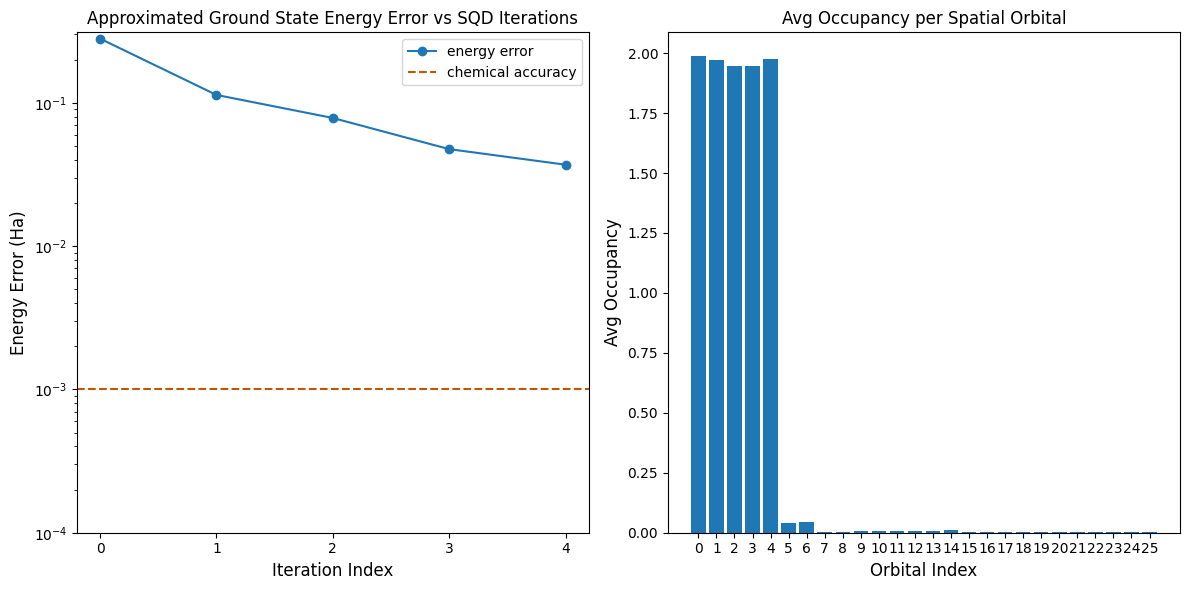

In [39]:
# Data for energies plot
x1 = range(len(result_history))
min_e = [
    min(result, key=lambda res: res.energy).energy + nuclear_repulsion_energy
    for result in result_history
]
e_diff = [abs(e - exact_energy) for e in min_e]
yt1 = [1.0, 1e-1, 1e-2, 1e-3, 1e-4]

# Chemical accuracy (+/- 1 milli-Hartree)
chem_accuracy = 0.001

# Data for avg spatial orbital occupancy
y2 = np.sum(result.orbital_occupancies, axis=0)
x2 = range(len(y2))

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot energies
axs[0].plot(x1, e_diff, label="energy error", marker="o")
axs[0].set_xticks(x1)
axs[0].set_xticklabels(x1)
axs[0].set_yticks(yt1)
axs[0].set_yticklabels(yt1)
axs[0].set_yscale("log")
axs[0].set_ylim(1e-4)
axs[0].axhline(
    y=chem_accuracy,
    color="#BF5700",
    linestyle="--",
    label="chemical accuracy",
)
axs[0].set_title("Approximated Ground State Energy Error vs SQD Iterations")
axs[0].set_xlabel("Iteration Index", fontdict={"fontsize": 12})
axs[0].set_ylabel("Energy Error (Ha)", fontdict={"fontsize": 12})
axs[0].legend()

# Plot orbital occupancy
axs[1].bar(x2, y2, width=0.8)
axs[1].set_xticks(x2)
axs[1].set_xticklabels(x2)
axs[1].set_title("Avg Occupancy per Spatial Orbital")
axs[1].set_xlabel("Orbital Index", fontdict={"fontsize": 12})
axs[1].set_ylabel("Avg Occupancy", fontdict={"fontsize": 12})

plt.tight_layout()
plt.show()